
Loaded dataset:
- X_raw shape: (101916, 128, 19)
- y_labels shape: (101916, 3)
- X_features shape: (101916, 76)

Class distribution:
Class 0: 33701 samples
Class 1: 28603 samples

Using device: cuda
Epoch [20/200] d_loss: 1.3784 g_loss: 0.7788
Epoch [40/200] d_loss: 1.3684 g_loss: 0.8050
Epoch [60/200] d_loss: 1.3969 g_loss: 0.6897
Epoch [80/200] d_loss: 1.3411 g_loss: 0.7171
Epoch [100/200] d_loss: 1.3361 g_loss: 0.7700
Epoch [120/200] d_loss: 1.2519 g_loss: 0.9173
Epoch [140/200] d_loss: 1.3644 g_loss: 0.7758
Epoch [160/200] d_loss: 1.4189 g_loss: 0.7709
Epoch [180/200] d_loss: 1.3905 g_loss: 0.6843
Epoch [200/200] d_loss: 1.4260 g_loss: 0.7045


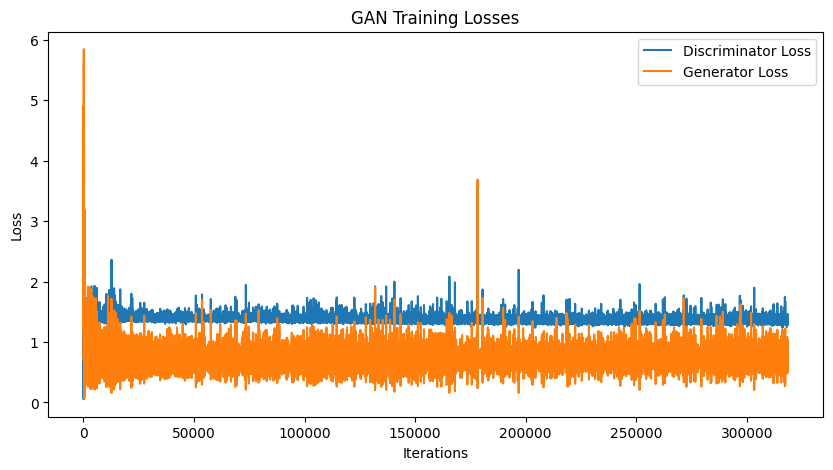

In [1]:


# ===================================================================
# STEP 4: GAN-BASED DATA AUGMENTATION
# ===================================================================

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# ===================================================================
# Load the saved dataset
# ===================================================================
try:
    data = np.load("/kaggle/input/largest-alzheimer-eeg-dataset/integrated_eeg_dataset.npz")
    X_raw = data['X_raw']          # Raw time-series data [N, T, C]
    y_labels = data['y_labels']    # Labels with metadata [N, 3]
    X_features = data['X_features']  # Extracted features [N, F]
    
    print("\nLoaded dataset:")
    print(f"- X_raw shape: {X_raw.shape}")
    print(f"- y_labels shape: {y_labels.shape}")
    print(f"- X_features shape: {X_features.shape}")
    
    # Extract binary labels (assuming first column is the label)
    y = y_labels[:, 0].astype(float).astype(int)
    print("\nClass distribution:")
    print(f"Class 0: {np.sum(y == 0)} samples")
    print(f"Class 1: {np.sum(y == 1)} samples")
    
except Exception as e:
    print(f"Error loading dataset: {e}")
    raise

# ===================================================================
# Prepare data for GAN training
# ===================================================================

# We'll use the raw time-series data for GAN training
# Normalize data to [-1, 1] range which works better with GANs
def normalize_data(data):
    # Normalize each channel separately
    for c in range(data.shape[2]):
        min_val = data[:, :, c].min()
        max_val = data[:, :, c].max()
        data[:, :, c] = 2 * ((data[:, :, c] - min_val) / (max_val - min_val)) - 1
    return data

X_normalized = normalize_data(X_raw.copy())

# Convert to PyTorch tensors
X_tensor = torch.FloatTensor(X_normalized)
y_tensor = torch.FloatTensor(y)

# Create dataset and dataloader
batch_size = 64
dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# ===================================================================
# GAN Model Definition
# ===================================================================

class Generator(nn.Module):
    """Generator network that creates synthetic EEG samples"""
    def __init__(self, latent_dim, output_shape):
        super(Generator, self).__init__()
        self.output_shape = output_shape  # (timesteps, channels)
        
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(128),
            nn.Linear(128, 256),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(256),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(512),
            nn.Linear(512, np.prod(output_shape)),
            nn.Tanh()  # Output in [-1, 1] range
        )
    
    def forward(self, z):
        # z: latent vector [batch_size, latent_dim]
        output = self.model(z)
        # Reshape to [batch_size, timesteps, channels]
        return output.view(-1, *self.output_shape)

class Discriminator(nn.Module):
    """Discriminator network that distinguishes real vs fake samples"""
    def __init__(self, input_shape):
        super(Discriminator, self).__init__()
        
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(np.prod(input_shape), 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()  # Output probability (0=fake, 1=real)
        )
    
    def forward(self, x):
        # x: input sample [batch_size, timesteps, channels]
        return self.model(x)

# ===================================================================
# GAN Training Setup
# ===================================================================

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\nUsing device: {device}")

# Model parameters
timesteps, channels = X_raw.shape[1], X_raw.shape[2]
latent_dim = 100

# Initialize models
generator = Generator(latent_dim, (timesteps, channels)).to(device)
discriminator = Discriminator((timesteps, channels)).to(device)

# Optimizers
lr = 0.0002
beta1 = 0.5
g_optimizer = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
d_optimizer = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))

# Loss function
criterion = nn.BCELoss()

# ===================================================================
# GAN Training Loop
# ===================================================================

num_epochs = 200
print_interval = 20
sample_interval = 50

# For tracking losses
g_losses = []
d_losses = []

for epoch in range(num_epochs):
    for i, (real_samples, _) in enumerate(dataloader):
        batch_size = real_samples.size(0)
        real_samples = real_samples.to(device)
        
        # Labels for real and fake samples
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)
        
        # =========================================
        # Train Discriminator
        # =========================================
        d_optimizer.zero_grad()
        
        # Train with real samples
        real_outputs = discriminator(real_samples)
        d_loss_real = criterion(real_outputs, real_labels)
        
        # Train with fake samples
        z = torch.randn(batch_size, latent_dim).to(device)
        fake_samples = generator(z)
        fake_outputs = discriminator(fake_samples.detach())
        d_loss_fake = criterion(fake_outputs, fake_labels)
        
        # Total discriminator loss
        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        d_optimizer.step()
        
        # =========================================
        # Train Generator
        # =========================================
        g_optimizer.zero_grad()
        
        # Generate fake samples and try to fool discriminator
        z = torch.randn(batch_size, latent_dim).to(device)
        fake_samples = generator(z)
        outputs = discriminator(fake_samples)
        g_loss = criterion(outputs, real_labels)  # We want discriminator to think these are real
        
        g_loss.backward()
        g_optimizer.step()
        
        # Save losses for plotting
        d_losses.append(d_loss.item())
        g_losses.append(g_loss.item())
    
    # Print training progress
    if (epoch + 1) % print_interval == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}] "
              f"d_loss: {d_loss.item():.4f} g_loss: {g_loss.item():.4f}")

# Plot training losses
plt.figure(figsize=(10, 5))
plt.plot(d_losses, label="Discriminator Loss")
plt.plot(g_losses, label="Generator Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("GAN Training Losses")
plt.legend()
plt.show()


In [2]:
from collections import Counter
# ===================================================================
# Generate Synthetic Samples
# ===================================================================

def generate_samples(generator, num_samples, latent_dim, device):
    """Generate synthetic EEG samples"""
    generator.eval()
    with torch.no_grad():
        z = torch.randn(num_samples, latent_dim).to(device)
        synthetic_samples = generator(z).cpu().numpy()
    return synthetic_samples

# Determine how many samples to generate per class to balance the dataset
min_value = min(y)  # Find lowest label value
y_shifted = y - min_value  # Shift all values to be non-negative
class_counts = np.bincount(y_shifted)  # Works now!

max_count = max(class_counts)
samples_to_generate = [max_count - count if count < max_count else 0 for count in class_counts] # Ensure no negative values

print("\nCurrent class distribution:")
for class_idx, count in enumerate(class_counts):
    print(f"Class {class_idx}: {count} samples")

print("\nGenerating synthetic samples to balance classes:")
# Create lists to store new samples and labels
new_samples = []
new_labels = []

for class_idx, count in enumerate(samples_to_generate):
    if count > 0:
        print(f"Generating {count} samples for class {class_idx}")
        synthetic_samples = generate_samples(generator, int(count), latent_dim, device)
        new_samples.append(synthetic_samples)
        
        # Create corresponding labels
        synthetic_labels = np.column_stack([
            np.full(count, class_idx),  # class label
            np.full(count, -1),  # subject ID (-1 for synthetic)
            np.full(count, "synthetic")  # dataset name
        ])
        new_labels.append(synthetic_labels)
        
        # Add to original dataset
        X_raw = np.concatenate([X_raw, synthetic_samples])
        y_labels = np.concatenate([y_labels, synthetic_labels])

# Combine all new samples and labels
if new_samples:  # Only concatenate if there are new samples
    synthetic_samples = np.concatenate(new_samples, axis=0)
    synthetic_labels = np.concatenate(new_labels, axis=0)
    
    # Add to original dataset
    X_raw = np.concatenate([X_raw, synthetic_samples])
    y_labels = np.concatenate([y_labels, synthetic_labels])

        

# Verify new class distribution
y_new = y_labels[:, 0].astype(float).astype(int)
print("\nNew class distribution after augmentation:")
print(f"Class 0: {np.sum(y_new == 0)} samples")
print(f"Class 1: {np.sum(y_new == 1)} samples")




Current class distribution:
Class 0: 1179 samples
Class 1: 33701 samples
Class 2: 28603 samples
Class 3: 38433 samples

Generating synthetic samples to balance classes:
Generating 37254 samples for class 0
Generating 4732 samples for class 1
Generating 9830 samples for class 2

New class distribution after augmentation:
Class 0: 108209 samples
Class 1: 38067 samples

Augmented dataset saved successfully to augmented_eeg_dataset.npz
Final dataset size: 205548 samples


In [5]:
# ===================================================================
# Save Augmented Dataset
# ===================================================================

try:
    save_path = "/kaggle/working/augmented_eeg_dataset.npz"
    np.savez(save_path, 
             X_raw=X_raw,          # Original + synthetic samples
             y_labels=y_labels)    # Corresponding labels
    
    print(f"\nAugmented dataset saved successfully to {save_path}")
    print(f"Final dataset size: {X_raw.shape[0]} samples")
    
except Exception as e:
    print(f"Error saving augmented dataset: {e}")


Augmented dataset saved successfully to /kaggle/working/augmented_eeg_dataset.npz
Final dataset size: 205548 samples


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from scipy.signal import welch
from scipy.integrate import simpson as simps  # Updated import


# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# ===================================================================
# Enhanced Feature Extraction Functions
# ===================================================================

def calculate_band_power(data, sf, band, window_sec=4, relative=False):
    """Calculate power in specific frequency band using Welch's method"""
    # Define window length
    nperseg = window_sec * sf
    
    # Compute modified periodogram (Welch)
    freqs, psd = welch(data, sf, nperseg=nperseg)
    
    # Frequency resolution
    freq_res = freqs[1] - freqs[0]
    
    # Find closest indices of band in frequency vector
    band_idx = np.logical_and(freqs >= band[0], freqs <= band[1])
    
    # Integral approximation of the spectrum using Simpson's rule
    bp = simps(psd[band_idx], dx=freq_res)
    
    if relative:
        bp /= simps(psd, dx=freq_res)
    
    return bp

from scipy.signal import welch
from scipy.integrate import simpson as simps
import numpy as np

def extract_enhanced_features(X, sfreq=128):
    """
    Extract enhanced EEG features using a vectorized approach for speed.
    
    X shape: [n_samples, n_timesteps, n_channels]
    """
    # Define EEG bands
    bands = {
        'delta': (0.5, 4), 'theta': (4, 8), 'alpha': (8, 13),
        'beta': (13, 30), 'gamma': (30, 50)
    }
    
    nperseg = X.shape[1] 
    
    # Compute Welch's method across the time axis (axis=1) for all samples/channels
    # The output psd shape is (n_samples, n_freqs, n_channels)
    freqs, psd = welch(X, fs=sfreq, nperseg=nperseg, axis=1)

    # --- THIS IS THE FIX ---
    # Transpose psd to shape (n_samples, n_channels, n_freqs) to match processing logic
    # Original shape: (101916, 65, 19) -> Transposed shape: (101916, 19, 65)
    psd = np.transpose(psd, (0, 2, 1))
    
    # Calculate band powers for all bands
    all_band_powers = []
    freq_res = freqs[1] - freqs[0]
    for band_name, band_limits in bands.items():
        band_idx = np.logical_and(freqs >= band_limits[0], freqs <= band_limits[1])
        
        # Now this indexing works because the last axis of psd is n_freqs (65)
        bp = simps(psd[:, :, band_idx], dx=freq_res, axis=-1)
        all_band_powers.append(bp)
    
    # Stack absolute band powers into a single array
    # Shape: (n_samples, n_channels, n_bands)
    abs_bp = np.stack(all_band_powers, axis=-1)
    
    # Calculate total power and relative band powers
    total_power = abs_bp.sum(axis=-1, keepdims=True)
    total_power[total_power == 0] = 1e-10
    rel_bp = abs_bp / total_power
    
    # Vectorize statistical features
    mean_across_timesteps = X.mean(axis=1)
    std_across_timesteps = X.std(axis=1)
    max_across_timesteps = X.max(axis=1)
    min_across_timesteps = X.min(axis=1)
    
    # Flatten features for the final feature vector
    n_samples = X.shape[0]
    abs_bp_flat = abs_bp.reshape(n_samples, -1)
    rel_bp_flat = rel_bp.reshape(n_samples, -1)

    # Combine all features horizontally
    enhanced_features = np.concatenate([
        rel_bp_flat,
        abs_bp_flat,
        mean_across_timesteps,
        std_across_timesteps,
        max_across_timesteps,
        min_across_timesteps
    ], axis=1)
    
    return enhanced_features

# ===================================================================
# Data Preparation Functions
# ===================================================================

def prepare_dataloaders(X, y, batch_size=64, test_size=0.2):
    """Create train/test dataloaders"""
    # Split into train/test
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=42, stratify=y)
    
    # Create TensorDatasets
    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)
    
    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, test_loader

# ===================================================================
# Training and Evaluation Functions
# ===================================================================

def train_model(model, train_loader, test_loader, num_epochs=30):
    """Train and evaluate the model"""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=5, factor=0.5)
    
    # Track metrics
    train_losses = []
    val_accuracies = []
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        # Validation
        val_acc = evaluate_model(model, test_loader)
        scheduler.step(val_acc)
        
        # Save metrics
        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)
        val_accuracies.append(val_acc)
        
        # Save best model
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), 'best_model.pth')
        
        print(f"Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.4f}, Val Acc: {val_acc:.4f}")
    
    # Plot training curves
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    return model

def evaluate_model(model, test_loader):
    """Evaluate model on test set"""
    device = next(model.parameters()).device
    model.eval()
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())
    
    accuracy = accuracy_score(all_labels, all_preds)
    return accuracy

def full_evaluation(model, test_loader, dataset_name=""):
    """Complete evaluation with metrics and confusion matrix"""
    device = next(model.parameters()).device
    model.eval()
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())
    
    # Classification report
    print(f"\nEvaluation on {dataset_name} dataset:")
    print(classification_report(all_labels, all_preds, target_names=['Class 0', 'Class 1']))
    
    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Class 0', 'Class 1'],
                yticklabels=['Class 0', 'Class 1'])
    plt.title(f'Confusion Matrix ({dataset_name})')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# ===================================================================
# Enhanced Data Preparation
# ===================================================================

def load_and_enhance_dataset(path, save_enhanced=False):
    """Load dataset and enhance with additional features"""
    data = np.load(path)
    X = data['X_raw']  # Shape: [N, T, C]
    y = data['y_labels'][:, 0].astype(float).astype(int)
    
    print(f"\nExtracting enhanced features for {X.shape[0]} samples...")
    X_enhanced = extract_enhanced_features(X)
    
    if save_enhanced:
        save_path = path.replace(".npz", "_enhanced.npz")
        np.savez(save_path, X_raw=X, X_enhanced=X_enhanced, y_labels=data['y_labels'])
        print(f"Saved enhanced dataset to {save_path}")
    
    # Convert to PyTorch tensors
    X_tensor = torch.FloatTensor(X_enhanced)
    y_tensor = torch.LongTensor(y)
    
    return X_tensor, y_tensor

# ===================================================================
# Enhanced CNN Model Architecture
# ===================================================================

class EnhancedEEGCNN(nn.Module):
    """CNN for EEG classification with enhanced features"""
    def __init__(self, input_channels, num_classes=2):
        super(EnhancedEEGCNN, self).__init__()
        
        # Feature extraction layers
        self.features = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm1d(32),
            nn.ELU(),
            nn.MaxPool1d(2),
            
            nn.Conv1d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm1d(64),
            nn.ELU(),
            nn.MaxPool1d(2),
            
            nn.Conv1d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm1d(128),
            nn.ELU(),
            nn.MaxPool1d(2),
        )
        
        # Classifier head
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * (input_channels // 8), 128),
            nn.Dropout(0.5),
            nn.ELU(),
            nn.Linear(128, num_classes)
        )
    
    def forward(self, x):
        # Input shape: [batch, features]
        # Add channel dimension for Conv1d [batch, 1, features]
        x = x.unsqueeze(1)
        features = self.features(x)
        output = self.classifier(features)
        return output

# ===================================================================
# Enhanced Evaluation Pipeline
# ===================================================================

def compare_enhanced_datasets(original_path, augmented_path):
    """Compare performance on original vs enhanced augmented datasets"""
    # Load and enhance datasets
    X_orig, y_orig = load_and_enhance_dataset(original_path)
    X_aug, y_aug = load_and_enhance_dataset(augmented_path, save_enhanced=True)
    
    # Prepare dataloaders
    orig_train, orig_test = prepare_dataloaders(X_orig, y_orig)
    aug_train, aug_test = prepare_dataloaders(X_aug, y_aug)
    
    # Get input size from enhanced features
    input_size = X_orig.shape[1]
    
    # Train on original data
    print("\nTraining on ENHANCED ORIGINAL dataset...")
    model_orig = EnhancedEEGCNN(input_size)
    train_model(model_orig, orig_train, orig_test)
    full_evaluation(model_orig, orig_test, "Enhanced Original")
    
    # Train on augmented data
    print("\nTraining on ENHANCED AUGMENTED dataset...")
    model_aug = EnhancedEEGCNN(input_size)
    train_model(model_aug, aug_train, aug_test)
    full_evaluation(model_aug, aug_test, "Enhanced Augmented")
    
    # Cross-evaluate models
    print("\nCross-evaluating enhanced models...")
    print("\nOriginal model tested on augmented data:")
    full_evaluation(model_orig, aug_test, "Original Model on Enhanced Augmented Data")
    
    print("\nAugmented model tested on original data:")
    full_evaluation(model_aug, orig_test, "Augmented Model on Enhanced Original Data")

# ===================================================================
# Run the enhanced comparison
# ===================================================================

if __name__ == "__main__":
    # Paths to your datasets
    original_dataset_path = "/kaggle/input/largest-alzheimer-eeg-dataset/integrated_eeg_dataset.npz"
    augmented_dataset_path = "/kaggle/working/augmented_eeg_dataset.npz"
    
    # Run the enhanced comparison
    compare_enhanced_datasets(original_dataset_path, augmented_dataset_path)


Extracting enhanced features for 101916 samples...

Extracting enhanced features for 205548 samples...
